# Lensing Map EDA #

### In this notebook, we examine weak lensing maps to identify where values are defined and undefined, as well as visualize weak lensing maps for the DC2 dataset ###

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('/home/shreyasc/bliss') # change this to your path

In [10]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate
import healpy as hp
import math
import pathlib

import numpy as np
import pandas as pd
import torch
from astropy.io import fits
from astropy.io.fits import Header
from astropy.wcs import WCS
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from tqdm import trange
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.colors import LinearSegmentedColormap
from bliss.surveys.dc2 import read_frame_for_band
import pickle

IMPORTANT: If you don't need to regenerate / load all the data and just want to visualize the maps, skip to the section titled "Load Previously Generated Data and Visualize Maps" and do not run the next few cells

In [8]:
data_dir = "/data/scratch/dc2local/run2.2i-dr6-v4/coadd-t3828-t3829/deepCoadd-results/"
image_lim = [4000, 4000]

In [7]:
BANDS = ("g", "i", "r", "u", "y", "z")

In [4]:
# extracted method from DC2 class, identical but provides minimal required functionality
def load_image_and_bg_files_list(bands, data_dir):
        img_pattern = "**/*/calexp*.fits"
        bg_pattern = "**/*/bkgd*.fits"
        image_files = []
        bg_files = []

        for band in bands:
            band_path = data_dir + str(band)
            img_file_list = list(pathlib.Path(band_path).glob(img_pattern))
            bg_file_list = list(pathlib.Path(band_path).glob(bg_pattern))

            image_files.append(sorted(img_file_list))
            bg_files.append(sorted(bg_file_list))
        n_image = len(bg_files[0])

        return n_image, image_files, bg_files

In [11]:
n_image, image_files, bg_files = load_image_and_bg_files_list(BANDS, data_dir)

In [12]:
image_lists = []
bg_lists = []
wcs_lists = []
for img_idx in trange(n_image):
    imlist, bglist, wcs = read_frame_for_band(image_files, bg_files, img_idx, len(BANDS), image_lim)
    image_lists.append(imlist)
    bg_lists.append(bglist)
    wcs_lists.append(WCS(Header.fromstring(wcs)))

100%|██████████| 2/2 [00:21<00:00, 10.61s/it]


NOTE: do not run the below cells unless you want to regenerate and save the entire shear / convergence map dataset (currently takes > 2 hours to load and save the entire data)

instead, consider skipping to the section titled "Load Previously Generated Data and Visualize Maps"

In [7]:
# now we can load the catalog
catalog = pd.read_csv("/data/scratch/shreyasc/cosmo_only.csv")

In [8]:
catalog

,Unnamed: 0,shear_2,ra,galaxy_id,shear_1,dec,convergence
0,0,-0.000170,54.842534,4937506723,0.000257,-34.218308,-0.000377
1,1,-0.000655,54.843331,4937521584,0.000011,-34.218300,-0.001224
2,2,-0.001352,54.852853,4937533577,0.000063,-34.217195,-0.001072
3,3,-0.004100,54.847085,4937618301,-0.000693,-34.216829,-0.001797
4,4,-0.003891,54.852781,4937638954,-0.000105,-34.215081,-0.001846
...,...,...,...,...,...,...,...
128290247,128290247,0.004900,61.153187,8833313718,0.000328,-38.479955,-0.014087
128290248,128290248,-0.030293,59.693886,8833313719,-0.000678,-38.413741,-0.010753
128290249,128290249,0.017399,61.133562,8833313723,-0.014894,-38.401485,-0.008421
128290250,128290250,0.008090,59.315926,8833313726,-0.003475,-38.432946,0.051260


In [9]:
# each value in the catalog is a unique truth galaxy
catalog["galaxy_id"].isna().sum()

0

In [10]:
# verifying the above again -- every value is unique
len(catalog["galaxy_id"].unique())

128290252

In [11]:
truth_cat = pd.read_csv('/data/scratch/shreyasc/truth_data_only.csv')
truth_ids = truth_cat["cosmodc2_id"]
cosmo_ids = catalog["galaxy_id"]
result = cosmo_ids[~cosmo_ids.isin(truth_ids)]
result

25           4938067646
40           4938348562
55           4938732730
56           4938773398
57           4938776097
                ...    
128290247    8833313718
128290248    8833313719
128290249    8833313723
128290250    8833313726
128290251    8833313727
Name: galaxy_id, Length: 84881745, dtype: int64

In [12]:
truth_cat

,Unnamed: 0,flux_u,flux_r,flux_z,cosmodc2_id,flux_i,truth_type,id,flux_y,ra,dec,flux_g
0,0,123.476220,144.206090,225.679340,8757401501,182.194630,1,8757401501,263.547420,56.851958,-38.677521,160.843890
1,1,10.705873,59.634422,113.052086,8750694182,99.906235,1,8750694182,125.482666,56.799616,-38.677104,21.402449
2,2,594.172550,499.428700,609.065300,8752812073,503.124300,1,8752812073,577.899050,56.883238,-38.676882,550.806760
3,3,51.661514,216.263960,307.122280,8750045581,266.654420,1,8750045581,336.939270,56.858170,-38.676674,117.508290
4,4,33.597460,56.280340,148.491640,8751841300,127.011505,1,8751841300,148.962170,56.889715,-38.676423,40.201370
...,...,...,...,...,...,...,...,...,...,...,...,...
47003936,47003936,8.443708,9.307166,9.119831,7883881935,8.888478,1,7883881935,9.006088,59.053383,-35.701810,9.737967
47003937,47003937,8.444751,18.461607,26.907806,7883590905,21.420214,1,7883590905,30.170162,59.051102,-35.700820,16.039595
47003938,47003938,25.756079,19.986082,16.253294,7881519644,18.068283,1,7881519644,18.557050,59.054715,-35.702075,23.031406
47003939,47003939,14.716217,14.089292,15.021297,7881928305,14.602583,1,7881928305,18.133670,59.053592,-35.701135,14.858120


In [17]:
img_ids = []
shear_1s = []
shear_2s = []
plocss = []

# respective location to the first image (our "absolute location") to put maps in perspective
respective_im_0_plocss = []
wcs_0 = wcs_lists[0]

ra = torch.tensor(catalog["ra"].values).numpy().squeeze()
dec = torch.tensor(catalog["dec"].values).numpy().squeeze()

truth_catalog_ra = torch.tensor(truth_cat["ra"].values).numpy().squeeze()
truth_catalog_dec = torch.tensor(truth_cat["dec"].values).numpy().squeeze()

shear_1 = torch.tensor(catalog["shear_1"].values)
shear_2 = torch.tensor(catalog["shear_2"].values)
for imidx in trange(len(wcs_lists)):
    wcs = wcs_lists[imidx]
    img_list = image_lists[imidx]
    plocs_lim = img_list[0].shape
    height = plocs_lim[0]
    width = plocs_lim[1]
    pt, pr = wcs.all_world2pix(ra, dec, 0)  # convert to pixel coordinates
    plocs = torch.stack((torch.tensor(pr), torch.tensor(pt)), dim=-1)

    plocs = (plocs.reshape(1, plocs.size()[0], 2))[0]

    # add another plocs thing for the galaxies taken from truth_data_only
    # compare those plocs to wcs from image
    # store galaxy locations of current image
    # plot galaxies overlaid on image if we can
    # alternatively we can overlay the map over the actual image (with galaxy)

    respective_im_0_pt, respective_im_0_pr = wcs_0.all_world2pix(ra, dec, 0)
    respective_im_0_plocs = torch.stack((torch.tensor(respective_im_0_pr), torch.tensor(respective_im_0_pt)), dim=-1)
    respective_im_0_plocs = (respective_im_0_plocs.reshape(1, respective_im_0_plocs.size()[0], 2))[0]
    
    # mask for current patch
    x0_mask = (plocs[:, 0] > 0) & (plocs[:, 0] < width)
    x1_mask = (plocs[:, 1] > 0) & (plocs[:, 1] < height)
    x_mask = x0_mask * x1_mask
    
    shear_1s.append(shear_1[x_mask])
    shear_2s.append(shear_2[x_mask])
    plocss.append(plocs[x_mask])
    respective_im_0_plocss.append(respective_im_0_plocs[x_mask])

100%|██████████| 98/98 [1:44:35<00:00, 64.03s/it]


In [40]:

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/image_lists.pkl", "wb") as f:
    pickle.dump(image_lists, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_1.pkl", "wb") as f:
    pickle.dump(shear_1s, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_2.pkl", "wb") as f:
    pickle.dump(shear_2s, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/plocs.pkl", "wb") as f:
    pickle.dump(plocss, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/im0_plocs.pkl", "wb") as f:
    pickle.dump(respective_im_0_plocss, f)

### Load Previously Generated Data and Visualize Maps ###

In [15]:
with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/image_lists.pkl", "rb") as f:
    image_lists = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_1.pkl", "rb") as f:
    shear_1s = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_2.pkl", "rb") as f:
    shear_2s = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/plocs.pkl", "rb") as f:
    plocss = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/im0_plocs.pkl", "rb") as f:
    respective_im_0_plocss = pickle.load(f)

In [16]:
num_shears = [len(shear_1) for shear_1 in shear_1s] # full image
print("Mean shear data points per image: ", np.mean(num_shears))
print("Standard dev shear data points per image: ", np.std(num_shears))
print("Maximum shears:", max(num_shears))
print("Minimum shears:", min(num_shears))

Mean shear data points per image:  223716.98979591837
Standard dev shear data points per image:  42295.0911033263
Maximum shears: 264491
Minimum shears: 152791


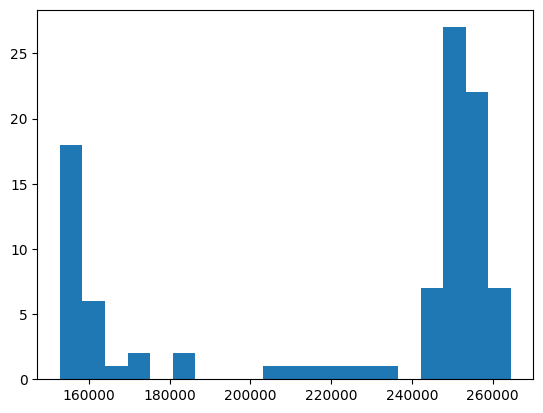

In [17]:
# Definitely not normally distributed...
n, bins, patches = plt.hist(num_shears, bins=20)
plt.show()

Run the three cells below to generate plots for horizontal and diagonal shear. Note that at present, it takes ~30 seconds to generate a single plot due to the calculations

In [18]:
def plot_single_shear_map(idx, grid_size, original_size, shear_type, show_zeros=False, image_overlay=False):
    image_list, s1, s2, ploc = image_lists[idx], shear_1s[idx], shear_2s[idx], plocss[idx]
    image = np.stack(image_list) # for printing image
    image = np.sum(image, axis=0)
    vmin = image.min().item()
    vmax = image.max().item()

    # Create a grid to represent the shear field
    shear_grid = np.zeros(grid_size)  # Initialize grid with zeros
    num_shears_per_grid_loc = np.zeros(grid_size, dtype=float) # + math.ulp(1.0) # denominator for average shear in grid locations, added epsilon due to possible divide by zero if no estimates in a given grid location

    sum_x_sq = np.zeros(grid_size) # running total of sums of squared x (for use in stdev calculations)

    # Assign shear values to the corresponding grid cells
    if shear_type == "Horizontal Shear":
        shear_og = s1
    elif shear_type == "Diagonal Shear":
        shear_og = s2
    else:
        print("Unknown shear type: ", shear_type, " not in {'Horizontal Shear', 'Diagonal Shear'}")
    for inner_idx, (pixel1, pixel2) in enumerate(ploc):
        # TODO: replace the below with an accumulator (torch.gather or torch.scatter(?)) since currently it replaces
        i = int((pixel1 / float(original_size[0])) * (grid_size[0] - 1))  # Scale pixel coordinate to fit the grid
        j = int((pixel2 / float(original_size[1])) * (grid_size[1] - 1))  # Scale pixel coordinate to fit the grid
        shear_grid[i, j] += shear_og[inner_idx] # accumulator for shear in grid location
        sum_x_sq[i, j] += (shear_og[inner_idx]**2) # add square to accumulator for stdev calculation
        num_shears_per_grid_loc += 1.0 # accumulator for denominator of grid locations

    shear_grid /= num_shears_per_grid_loc # average across grid size
    shear_grid *= (10**6) # scale up from 1e-6
    n = (original_size[0] / grid_size[0]) * (original_size[1] / grid_size[1]) # number of locations in each grid
    sum_x_sq *= (10**6)
    grid_stdev = np.sqrt((sum_x_sq / n) - (shear_grid ** 2))
    print("Mean SD of shear value dispersion per grid point, including zeros: ", np.mean(grid_stdev))

    print("X: ", "(" + str(torch.min(respective_im_0_plocss[idx][:,0]).item()) + "," + str(torch.max(respective_im_0_plocss[idx][:,0]).item()) + ")", "Y: (" + str(torch.min(respective_im_0_plocss[idx][:,1]).item()) + "," + str(torch.max(respective_im_0_plocss[idx][:,1]).item()) + ")") # quick way of getting positions of current image; TODO: get these from the image itself?
    # print total zero count on grid
    zero_mask = shear_grid == 0
    zero_count = np.count_nonzero(zero_mask)
    print("Grid Zero Count: ", zero_count, "out of", grid_size[0]*grid_size[1],"(" + str(100*zero_count/(grid_size[0]*grid_size[1]))+"%)")

    if image_overlay:
        plt.imshow(image)

    if show_zeros: # show zero values as black 
        masked_shear_grid = np.ma.masked_where(zero_mask, shear_grid)
        cmap = matplotlib.cm.coolwarm
        cmap.set_bad(color='black', alpha=0.3)
        plt.imshow(masked_shear_grid, cmap=cmap, vmin = np.min(shear_grid), vmax = np.max(shear_grid), extent=(0, original_size[0], 0, original_size[1]))
    else:
        plt.imshow(shear_grid, cmap="coolwarm", vmin = np.min(shear_grid), vmax = np.max(shear_grid), extent=(0, original_size[0], 0, original_size[1]))
    plt.colorbar(label=shear_type)
    plt.title(shear_type)
    plt.grid(True)
    plt.show()

Mean SD of shear value dispersion per grid point, including zeros:  0.9823493186191703
X:  (0.04611256474345282,3999.9832583600946) Y: (0.016407462147981278,3999.965547014017)
Grid Zero Count:  56009 out of 160000 (35.005625%)


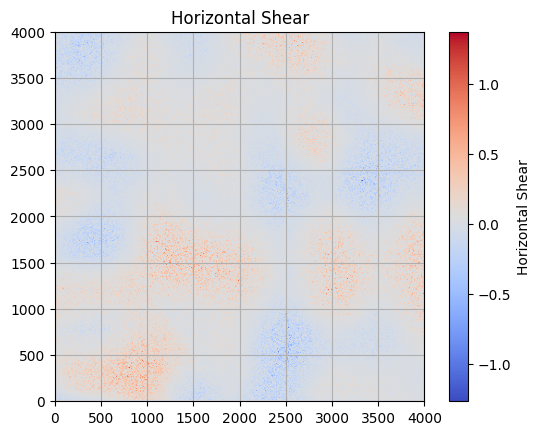

Mean SD of shear value dispersion per grid point, including zeros:  1.6196905091156566
X:  (3900.008670337549,7899.992124928339) Y: (0.006956738765438786,3999.9889368479344)
Grid Zero Count:  40112 out of 160000 (25.07%)


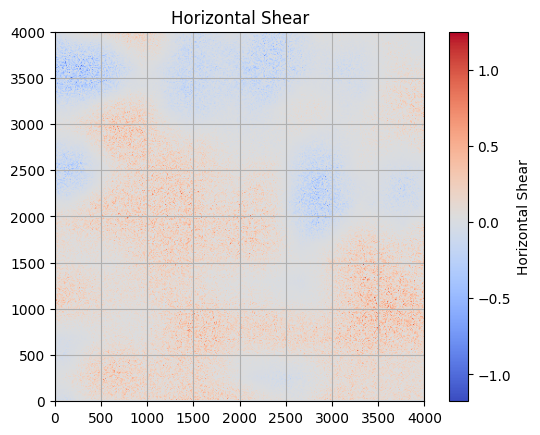

Mean SD of shear value dispersion per grid point, including zeros:  1.739966863482253
X:  (7900.002175155227,11899.984087610244) Y: (0.010995285532771959,3999.9785152753066)
Grid Zero Count:  33500 out of 160000 (20.9375%)


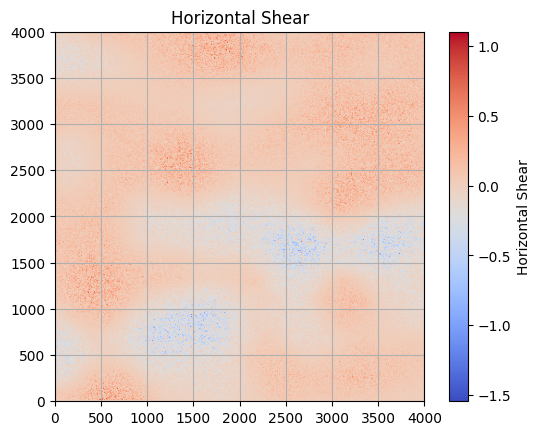

Mean SD of shear value dispersion per grid point, including zeros:  1.553980335664826
X:  (11900.032426342357,15899.99723683652) Y: (0.0034864495137298945,3999.982832651327)
Grid Zero Count:  34593 out of 160000 (21.620625%)


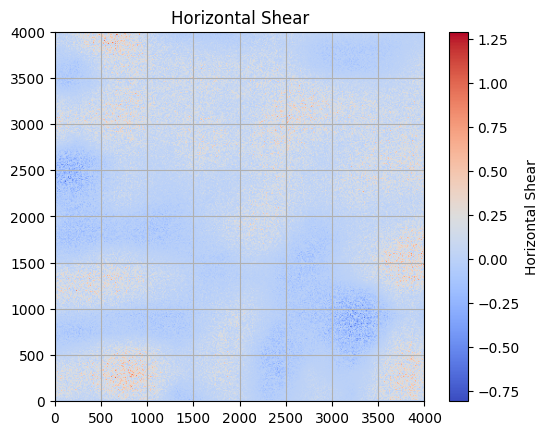

In [19]:
# scale is 10 pixels : 1 point on graph (as defined below), change if necessary
grid_size = (400, 400)  # Define the size of the grid
original_size = (4000, 4000)
shear_type = "Horizontal Shear"
for idx in range(4): #98 patches in total, this is just the first few
    plot_single_shear_map(idx, grid_size, original_size, shear_type, show_zeros=False, image_overlay=True) # change show_zeros to visualize the maps alone

Mean SD of shear value dispersion per grid point, including zeros:  1.2281727233818258
X:  (0.04611256474345282,3999.9832583600946) Y: (0.016407462147981278,3999.965547014017)
Grid Zero Count:  56009 out of 160000 (35.005625%)


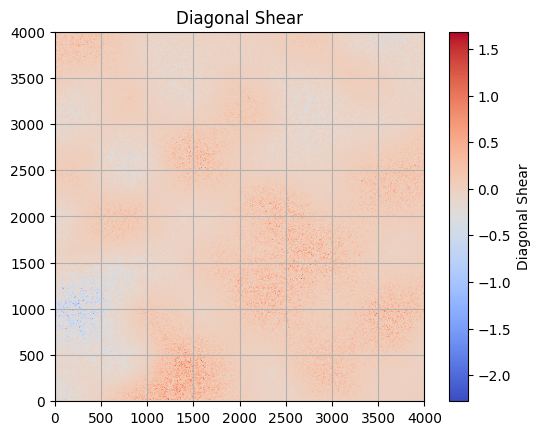

Mean SD of shear value dispersion per grid point, including zeros:  1.3582256008320515
X:  (3900.008670337549,7899.992124928339) Y: (0.006956738765438786,3999.9889368479344)
Grid Zero Count:  40112 out of 160000 (25.07%)


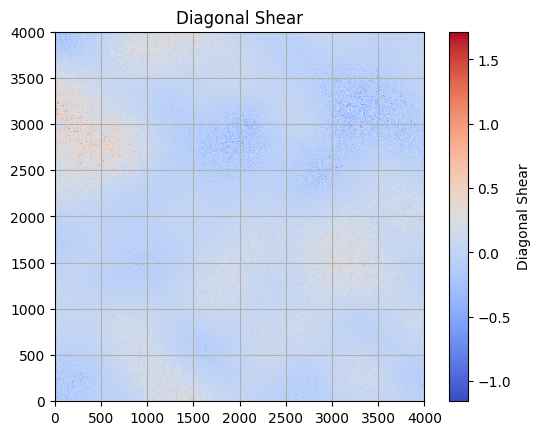

Mean SD of shear value dispersion per grid point, including zeros:  1.5490115717698811
X:  (7900.002175155227,11899.984087610244) Y: (0.010995285532771959,3999.9785152753066)
Grid Zero Count:  33500 out of 160000 (20.9375%)


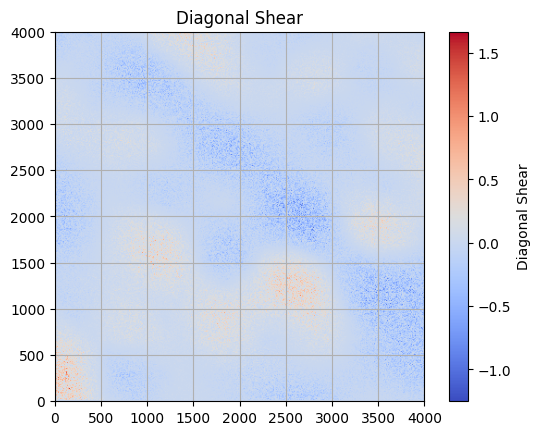

Mean SD of shear value dispersion per grid point, including zeros:  1.7065500822488906
X:  (11900.032426342357,15899.99723683652) Y: (0.0034864495137298945,3999.982832651327)
Grid Zero Count:  34593 out of 160000 (21.620625%)


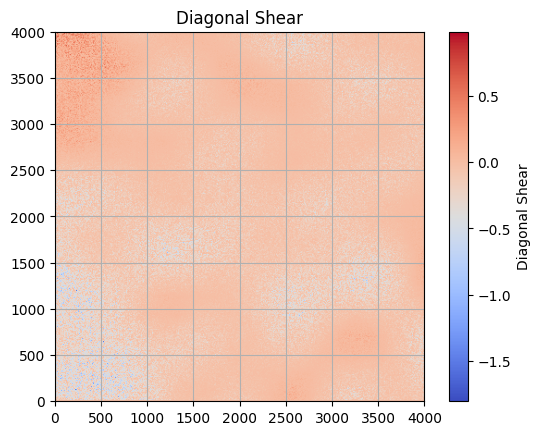

In [121]:
# scale is 10x10 pixels : 1 point on graph (as defined below)
grid_size = (400, 400)  # Define the size of the grid
original_size = (4000, 4000)
shear_type = "Diagonal Shear"
for idx in range(4): #98 patches in total, this is just the first few
    plot_single_shear_map(idx, grid_size, original_size, shear_type, show_zeros=False) # change or remove show_zeros to visualize the maps alone